In [24]:
## Table & Visualization Libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy
import pickle
import json

## Prediction Libraries
from sklearn.metrics import classification_report, confusion_matrix, \
accuracy_score, plot_confusion_matrix, auc, roc_curve

## Cross-Validation Libraries
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold, GridSearchCV

## Model Libraries
from xgboost import XGBClassifier

In [25]:
## Change this to your new training data
df = pd.read_csv("df_cleaned.csv")
df = df.drop_duplicates(subset='website')

In [26]:
df.head()

,Unnamed: 0,merchant_name,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist,contact_us_score,tnc_score,links_response,website,fraud_score,label
0,0,CV.ASIATRIPINDONESIA,0.000000,1.0,1.0,1.0,0.0,1.0,1.0,100.0,100.0,{'https://asiatrip.id/reseller/': '<Response [...,http://asiatrip.id/,0.000000,APPROVED
1,1,Pt.BloomingLotusYoga,70.000000,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,{'http://www.blooming-lotus-yoga.com/bliss-mag...,https://www.blooming-lotus-yoga.com,0.000000,APPROVED
2,2,YayasanGreenSejahtera,11.111111,1.0,1.0,1.0,1.0,1.0,1.0,100.0,100.0,"{'': 'No Response/Timeout', 'https://greenseja...",https://greensejahterafoundation.com/,0.000000,APPROVED
3,3,PTMatairTerraSolusi,12.500000,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,"{'': 'No Response/Timeout', 'https://www.matai...",http://www.matair.co.id,0.666667,APPROVED
4,4,SimplyMii,0.000000,1.0,1.0,1.0,0.0,0.0,0.0,100.0,0.0,{'https://www.simplymii.com/products/category/...,https://www.simplymii.com/,0.000000,APPROVED


In [27]:
y = df['label'].apply(lambda x: 1 if x == 'REJECTED' else 0)

In [28]:
X = df.iloc[:, 2:9]

In [29]:
## Binarize broken_link_score, with threshold 50.0
X["broken_link_score"] = (X["broken_link_score"] < 50.0)

In [30]:
for col in X:
    X[col] = X[col].astype(int)

In [31]:
X.head()

,broken_link_score,link_contact_us_exist,cu_email_exist,cu_phone_number_exist,link_about_us_exist,link_tnc_exist,tnc_refund_policy_exist
0,1,1,1,1,0,1,1
1,0,1,1,1,1,1,1
2,1,1,1,1,1,1,1
3,1,0,0,0,1,0,0
4,1,1,1,1,0,0,0


In [32]:
X.shape

(292, 7)

In [33]:
df.groupby("label").size()

label
APPROVED    215
REJECTED     77
dtype: int64

In [34]:
X.columns

Index(['broken_link_score', 'link_contact_us_exist', 'cu_email_exist',
       'cu_phone_number_exist', 'link_about_us_exist', 'link_tnc_exist',
       'tnc_refund_policy_exist'],
      dtype='object')

## Cross Validation & Hyperparameter Tuning
Adopted from: https://weina.me/nested-cross-validation/

#### Data Splitting

In [35]:
## Divide data into train and "unseen" test set
## Unseen test set will be used for final testing after best hyperparameter sets chose
X_train, X_test_unseen, y_train, y_test_unseen = train_test_split(X, y, test_size=0.25, random_state=42)

In [36]:
y_train.value_counts()

0    159
1     60
Name: label, dtype: int64

In [37]:
y_test_unseen.value_counts()

0    56
1    17
Name: label, dtype: int64

#### Find The Best Hyperparameter Candidates

In [85]:
## Define a parameters grid
p_grid = {"learning_rate":[0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
          "max_depth":[3, 4, 5, 6, 8, 10, 12, 15],
          "min_child_weight" : [1, 3, 5, 7]}

In [86]:
## Split train data to 5 (outer) folds
skfold = StratifiedKFold(n_splits=5)

In [87]:
i = 1
folds = []
for train_index_outer, test_index_outer in skfold.split(X_train, y_train):
    fold_data = {}
    
    print("Outer Fold %s" % i)
    data_X_train = X_train.iloc[train_index_outer]
    data_y_train = y_train.iloc[train_index_outer]
    data_X_test = X_train.iloc[test_index_outer]
    
    ## Define model
    model = XGBClassifier(random_state=0)
    
    ## Do cross validation in inner fold, get the best params
    clf = GridSearchCV(model, p_grid, scoring='roc_auc', cv=skfold)
    clf.fit(data_X_train, data_y_train)
    print("Best Params: %s" % clf.best_params_)
    print("Best Avg. Score: %s" % clf.best_score_)
    fold_data['outer_fold'] = i
    fold_data['best_param'] = clf.best_params_
    fold_data['best_score'] = clf.best_score_
    folds.append(fold_data)
    
    i+=1

Outer Fold 1
Best Params: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5}
Best Avg. Score: 0.919128205128205
Outer Fold 2
Best Params: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1}
Best Avg. Score: 0.9389846153846154
Outer Fold 3
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 7}
Best Avg. Score: 0.9341333333333333
Outer Fold 4
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5}
Best Avg. Score: 0.9272786324786324
Outer Fold 5
Best Params: {'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 7}
Best Avg. Score: 0.9122786324786324


In [88]:
folds

[{'outer_fold': 1,
  'best_param': {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5},
  'best_score': 0.919128205128205},
 {'outer_fold': 2,
  'best_param': {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1},
  'best_score': 0.9389846153846154},
 {'outer_fold': 3,
  'best_param': {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 7},
  'best_score': 0.9341333333333333},
 {'outer_fold': 4,
  'best_param': {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5},
  'best_score': 0.9272786324786324},
 {'outer_fold': 5,
  'best_param': {'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 7},
  'best_score': 0.9122786324786324}]

In [89]:
df_outer_fold_result = pd.DataFrame({"outer_fold":[], "learning_rate":[], "max_depth":[],\
                                     "min_child_weight":[], "best_score":[]})
for fold in folds:
    res = pd.concat([pd.DataFrame(fold['best_param'], index=[0]),\
                    pd.DataFrame(fold, index=[0]).drop('best_param', axis=1)], axis=1)
    df_outer_fold_result = pd.concat([df_outer_fold_result, res])

In [92]:
df_outer_fold_result

,outer_fold,learning_rate,max_depth,min_child_weight,best_score
0,1.0,0.10,3.0,5.0,0.919128
0,2.0,0.20,5.0,1.0,0.938985
0,3.0,0.05,3.0,7.0,0.934133
0,4.0,0.05,3.0,5.0,0.927279
0,5.0,0.15,3.0,7.0,0.912279


#### Test All Candidates To Unseen Data

In [94]:
pred_class = []
pred_proba = []
pred_auc = []
for fold in folds:
    model = XGBClassifier(random_state=0,\
                          learning_rate=fold['best_param']['learning_rate'],\
                          max_depth=fold['best_param']['max_depth'],\
                          min_child_weight=fold['best_param']['min_child_weight'])
    
    ## Predict
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test_unseen)
    y_pred_proba = model.predict_proba(X_test_unseen)
    
    ## Print metrics
    print("==============================")
    print("Fold %s" % fold['outer_fold'])
    print("Parameter: %s" % fold['best_param'])
    fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
    auc_score = auc(fpr, tpr)
    accuracy = accuracy_score(y_test_unseen, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
    precision = tp / (tp + fp)
    recall = tp / (tp + fn)
    f1_score = 2 * (precision * recall) / (precision + recall)
    
    print("AUC: %.3f" % auc_score)
    print("Accuracy: %.3f " % accuracy)
    print("Precision: %.3f " % precision)
    print("Recall: %.3f " % recall)
    print("F1 Score: %.3f " % f1_score)
    print("True Positive: %s" % tp)
    print("False Positive: %s" % fp)
    print("True Negative: %s" % tn)
    print("False Negative: %s" % fn)
    print("==============================")
    
    pred_class.append(y_pred)
    pred_proba.append(y_pred_proba)
    pred_auc.append(auc_score)

Fold 1
Parameter: {'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 5}
AUC: 0.950
Accuracy: 0.890 
Precision: 0.737 
Recall: 0.824 
F1 Score: 0.778 
True Positive: 14
False Positive: 5
True Negative: 51
False Negative: 3
Fold 2
Parameter: {'learning_rate': 0.2, 'max_depth': 5, 'min_child_weight': 1}
AUC: 0.942
Accuracy: 0.836 
Precision: 0.619 
Recall: 0.765 
F1 Score: 0.684 
True Positive: 13
False Positive: 8
True Negative: 48
False Negative: 4
Fold 3
Parameter: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 7}
AUC: 0.953
Accuracy: 0.890 
Precision: 0.737 
Recall: 0.824 
F1 Score: 0.778 
True Positive: 14
False Positive: 5
True Negative: 51
False Negative: 3
Fold 4
Parameter: {'learning_rate': 0.05, 'max_depth': 3, 'min_child_weight': 5}
AUC: 0.952
Accuracy: 0.890 
Precision: 0.737 
Recall: 0.824 
F1 Score: 0.778 
True Positive: 14
False Positive: 5
True Negative: 51
False Negative: 3
Fold 5
Parameter: {'learning_rate': 0.15, 'max_depth': 3, 'min_child_weight': 

In [102]:
## Best hyperparameter test to unseen data
fold_best = folds[np.argmax(pred_auc)]

In [103]:
## Predict with the best params
model = XGBClassifier(random_state=0,\
                          learning_rate=fold_best['best_param']['learning_rate'],\
                          max_depth=fold_best['best_param']['max_depth'],\
                          min_child_weight=fold_best['best_param']['min_child_weight'])
model.fit(X_train, y_train)
y_pred = model.predict(X_test_unseen)
y_pred_proba = model.predict_proba(X_test_unseen)

In [105]:
fpr, tpr, thresholds = roc_curve(y_test_unseen, y_pred_proba[:,1])
auc_score = auc(fpr, tpr)
accuracy = accuracy_score(y_test_unseen, y_pred)
tn, fp, fn, tp = confusion_matrix(y_test_unseen, y_pred).ravel()
precision = tp / (tp + fp)
recall = tp / (tp + fn)
f1_score = 2 * (precision * recall) / (precision + recall)

print("AUC: %.3f" % auc_score)
print("Accuracy: %.3f " % accuracy)
print("Precision: %.3f " % precision)
print("Recall: %.3f " % recall)
print("F1 Score: %.3f " % f1_score)
print("True Positive: %s" % tp)
print("False Positive: %s" % fp)
print("True Negative: %s" % tn)
print("False Negative: %s" % fn)

AUC: 0.963
Accuracy: 0.904 
Precision: 0.778 
Recall: 0.824 
F1 Score: 0.800 
True Positive: 14
False Positive: 4
True Negative: 52
False Negative: 3


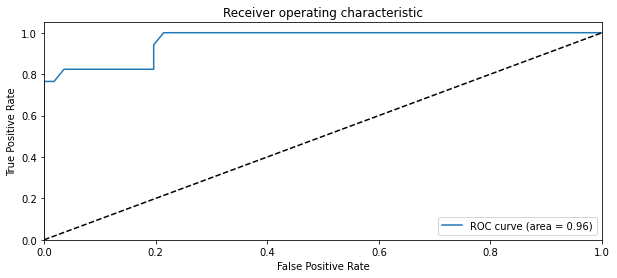

In [106]:
## ROC AUC Graph
plt.figure(figsize=(10,4))
plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % (auc_score))
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

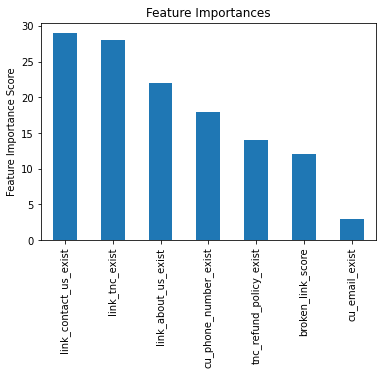

In [108]:
## Feature Importance based on XGBoost FScore
feat_imp = pd.Series(model.get_booster().get_fscore()).sort_values(ascending=False)
feat_imp.plot(kind='bar', title='Feature Importances')
plt.ylabel('Feature Importance Score')
plt.show()

## Dump To Pickle

In [54]:
# clf = model_choice
# clf = clf.fit(X, y)
# pickle.dump(clf, open('../models/model.pickle', 'wb'))